In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

use_gpu = False

Mounted at /content/drive


Next, let's install the pytorch interface for XLNet by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT, BERT, and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow)

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with transfer learning models. In addition to supporting a variety of different pre-trained language models (and future models to come - just a few short months after the publication of BERT and XLNet, both have been outperformed by new models!), the library also includes pre-built modifications of different models suited to your specific task. For example, in this tutorial we will use XLNetForSequenceClassification, but the library also includes model modifications designed for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying transfer learning models for your purposes.


In [ ]:
!pip install pytorch-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 12.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-man

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA L4'

## Load Dataset


We'll use The Corpus of Linguistic Acceptability (CoLA) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. The data is as follows:

**Column 1**:	the code representing the source of the sentence.

**Column 2**:	the acceptability judgment label (0=unacceptable, 1=acceptable).

**Column 3**:	the acceptability judgment as originally notated by the author.

**Column 4**:	the sentence.

Download the dataset from this link, extract, and move them to your local drive.

https://nyu-mll.github.io/CoLA/

Both tokenized and raw versions of the data are available. We will use the **raw** version because we need to use the XLNet tokenizer to break the text down into tokens and chunks that the model will recognize.

In [ ]:
# # Upload the train file from your local drive
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/COMP4432_project/test/train_AG/train.csv", delimiter='\t', header=None, names=['label','Title', 'sentence'])
df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/COMP4432_project/test/train_AG/train.csv",names=['label','Title', 'sentence'])

In [ ]:
# Create sentence and label lists
df=df[:8000]
sentences = df.Title.values

In [ ]:
df

,label,Title,sentence
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
7995,3,Small Index Gains Across The Board,Chips are being credited with keeping the Nasd...
7996,4,Gene Tweaking Turns Couch Potato Mice Into Racers,Altering a single gene turned ordinary mice in...
7997,4,Cisco and Microsoft CRM Team for Medium Busine...,"August 23, 2004 - (HostReview.com) - Cisco Sys..."
7998,4,Sophos: Worm Spies on Innocent Computer Users,Sophos believes that the W32/Rbot-GR worm is e...


In [ ]:
df.sample(100)

,label,Title,sentence
3622,3,Oil Above \$47 After New Record,SINGAPORE (Reuters) - Oil prices struck anothe...
1266,2,Giants Clobber Expos 8-5 (AP),AP - Pinch-hitter Ricky Ledee hit a tiebreakin...
7714,4,"Cisco, Microsoft step up small-business push",The two tech giants bring corporate-level cust...
6554,2,Nesterenko surprises field with speed,Winning the 100 meters at the Olympics isn #39...
1548,2,Basketball: China #39;s Yao Takes Anger Out on...,ATHENS (Reuters) - An angry Yao Ming took his ...
...,...,...,...
6397,3,Oil Falls from Highs After Missing \$50,Oil prices eased from new highs on Friday as d...
2118,4,Cassini Spacecraft Discovers 2 More Moons Arou...,The planet with the second largest number of m...
7362,2,"Spain, Lithuania Go 5-0 in Men's Hoops (AP)",AP - Spain could have tanked its game against ...
6463,2,Wrong target drama costs US shooting gold,China #39;s Jia Zhanbo claimed the gold medal ...


In [ ]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = df.label.values-1

In [ ]:
len(sentences)

8000

We need to add special tokens ("[SEP]" and "[CLS]") at the beginning and end of each sentence for XLNet to work properly.

For BERT, the special token pattern looks like this:

    [CLS] + Sentence_A + [SEP] + Sentence_B + [SEP]

Whereas with XLNet the token pattern looks like this:

    Sentence_A + [SEP] + Sentence_B + [SEP] + [CLS]
    
For single sentence inputs here, we just need to add [SEP] and [CLS] to the end:

In [ ]:
df.shape

(120000, 3)

In [ ]:
len(temp_cats)

NameError: name 'temp_cats' is not defined

In [ ]:
num_cats=4
temp_cats = [[0] * num_cats for _ in range(len(labels))]
for i in range(len(labels)):
    temp_cats[i][labels[i]-1]=1
labels=temp_cats
# # temp_cats = [[0] * num_cats for _ in range(len(validation_labels))]
# # for i in range(len(validation_labels)):
# #     temp_cats[i][validation_labels[i]]=1
# # val_cats=temp_cats
# # temp_cats = [[0] * num_cats for _ in range(len(test_cats))]
# # for i in range(len(test_cats)):
#   # temp_cats[i][test_cats[i]]=1
# # test_cats=temp_cats

In [ ]:
sentences

['Wall St. Bears Claw Back Into the Black (Reuters) [SEP] [CLS]',
 'Carlyle Looks Toward Commercial Aerospace (Reuters) [SEP] [CLS]',
 "Oil and Economy Cloud Stocks' Outlook (Reuters) [SEP] [CLS]",
 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) [SEP] [CLS]',
 'Oil prices soar to all-time record, posing new menace to US economy (AFP) [SEP] [CLS]',
 'Stocks End Up, But Near Year Lows (Reuters) [SEP] [CLS]',
 'Money Funds Fell in Latest Week (AP) [SEP] [CLS]',
 'Fed minutes show dissent over inflation (USATODAY.com) [SEP] [CLS]',
 'Safety Net (Forbes.com) [SEP] [CLS]',
 'Wall St. Bears Claw Back Into the Black [SEP] [CLS]',
 "Oil and Economy Cloud Stocks' Outlook [SEP] [CLS]",
 'No Need for OPEC to Pump More-Iran Gov [SEP] [CLS]',
 'Non-OPEC Nations Should Up Output-Purnomo [SEP] [CLS]',
 'Google IPO Auction Off to Rocky Start [SEP] [CLS]',
 'Dollar Falls Broadly on Record Trade Gap [SEP] [CLS]',
 'Rescuing an Old Saver [SEP] [CLS]',
 'Kids Rule for Back-to-School [SEP] [C

## Inputs

Next, import the XLNet tokenizer, used to convert our text into tokens that correspond to XLNet's vocabulary.

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 798011/798011 [00:00<00:00, 2616236.69B/s]


Tokenize the first sentence:
['▁wall', '▁', 'st', '.', '▁bears', '▁c', 'law', '▁back', '▁into', '▁the', '▁black', '▁', '(', 're', 'uter', 's', ')', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


XLNet requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the XLNet tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

Although we can have variable length input sentences, XLNet does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length.

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length.

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) `pad_sequences` is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
MAX_LEN = 128

In [ ]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create the attention masks

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_masks.shape

torch.Size([108000, 128])

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
train_labels

tensor([1, 0, 3,  ..., 1, 1, 0])

## Train Model

Now that our input data is properly formatted, it's time to fine tune the XLNet model.

For this task, we first want to modify the pre-trained model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained model, each has different top layers and output types designed to accomodate their specific NLP task.  

We'll load [XLNetForSequenceClassification](https://github.com/huggingface/pytorch-transformers/blob/master/pytorch_transformers/modeling_xlnet.py#L1076). This is the normal XLNet model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained XLNet model and the additional untrained classification layer is trained on our specific task.

### The Fine-Tuning Process

Because the pre-trained model layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.

Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on transfer learning models like BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea. We'll cover the broader scope of transfer learning in NLP in a future post.  



OK, let's load XLNet! There are a few different pre-trained XLNet models available. "xlnet-base-cased" means the version that has both upper and lowercase letters ("cased") and is the smaller version of the two ("base" vs "large").

In [ ]:
# from transformers import XLNetTokenizer, XLNetForSequenceClassification
# import torch

# tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
# model = XLNetForSequenceClassification.from_pretrained('xlnet-large-cased')

# input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
# labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
# outputs = model(input_ids, labels=labels)
# loss, logits = outputs[:2]

In [ ]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top.
from transformers import XLNetTokenizer, XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=4)
model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [ ]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []
best_model=None
best_auc=100
# Number of training epochs (authors recommend between 2 and 4)
epochs = 20
val_loss_set=[]
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  if(best_auc<eval_accuracy/nb_eval_steps):
    best_model=model
    best_auc=eval_accuracy/nb_eval_steps
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1630.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss: 1.0239665273544007


Epoch:   5%|▌         | 1/20 [01:30<28:37, 90.42s/it]

Validation Accuracy: 0.7680288461538461
Train loss: 0.5860025516126008


Epoch:  10%|█         | 2/20 [03:02<27:21, 91.21s/it]

Validation Accuracy: 0.8185096153846154
Train loss: 0.46724442649731596


Epoch:  15%|█▌        | 3/20 [04:33<25:53, 91.40s/it]

Validation Accuracy: 0.8269230769230769
Train loss: 0.37669981501798716


Epoch:  20%|██        | 4/20 [06:05<24:23, 91.48s/it]

Validation Accuracy: 0.8269230769230769
Train loss: 0.3147468934808157


Epoch:  25%|██▌       | 5/20 [07:36<22:52, 91.50s/it]

Validation Accuracy: 0.8209134615384616
Train loss: 0.252219768752039


Epoch:  30%|███       | 6/20 [09:08<21:20, 91.50s/it]

Validation Accuracy: 0.8293269230769231
Train loss: 0.2060405402320676


Epoch:  35%|███▌      | 7/20 [10:39<19:49, 91.51s/it]

Validation Accuracy: 0.8269230769230769
Train loss: 0.16702976760215463


Epoch:  40%|████      | 8/20 [12:11<18:18, 91.52s/it]

Validation Accuracy: 0.8377403846153846


Epoch:  40%|████      | 8/20 [12:29<18:44, 93.68s/it]


KeyboardInterrupt: 

## Training Evaluation

Let's take a look at our training loss over all batches:

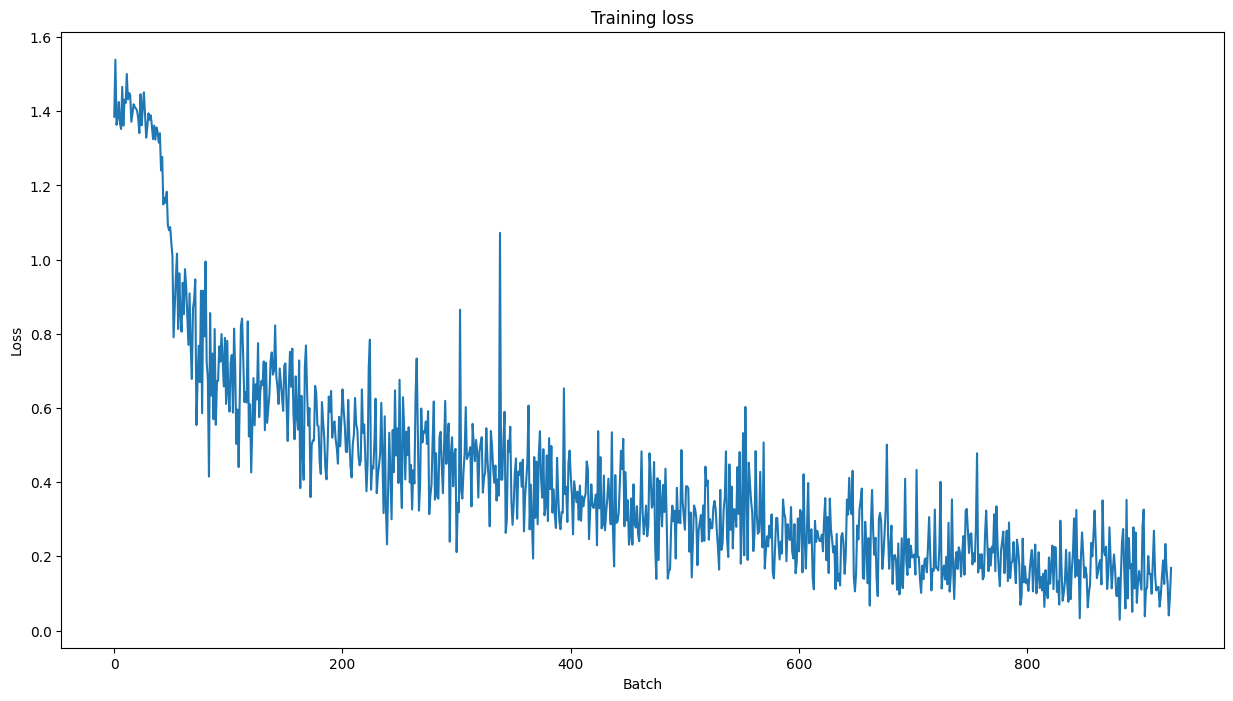

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate on Holdout Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

In [ ]:
# Upload the test file from your local drive
from google.colab import files
uploaded = files.upload()


Saving out_of_domain_dev.tsv to out_of_domain_dev.tsv


In [ ]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [ ]:
matthews_set

[0.049286405809014416,
 0.014456362470655182,
 0.5510387687779837,
 0.2757127976394358,
 -0.007053982594841415,
 0.6397114734243627,
 0.6831300510639732,
 -0.06788442333021306,
 0.5673665146135802,
 0.4581228472908512,
 0.39405520311955033,
 0.6546536707079772,
 0.6979824404521128,
 0.5447047794019222,
 0.5447047794019222,
 0.41281272698065485,
 0.0]

In [ ]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


NameError: name 'predictions' is not defined

In [ ]:
matthews_corrcoef(flat_true_labels, flat_predictions)

In [ ]:
import pandas as pd


train_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/COMP4432_project/test/train_AG/train.csv', header=None)
train_df['text'] = train_df.iloc[:, 1] + " " + train_df.iloc[:, 2]
train_df = train_df.drop(train_df.columns[[1, 2]], axis=1)
train_df.columns = ['label', 'text']
train_df = train_df[['text', 'label']]
train_df['text'] = train_df['text'].apply(lambda x: x.replace('\\', ' '))
train_df['label'] = train_df['label'].apply(lambda x:x - 1)

# eval_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/COMP4432_project/test/train_AG/test.csv', header=None)
# eval_df['text'] = eval_df.iloc[:, 1] + " " + eval_df.iloc[:, 2]
# eval_df = eval_df.drop(eval_df.columns[[1, 2]], axis=1)
# eval_df.columns = ['label', 'text']
# eval_df = eval_df[['text', 'label']]
# eval_df['text'] = eval_df['text'].apply(lambda x: x.replace('\\', ' '))
# eval_df['label'] = eval_df['label'].apply(lambda x:x-1)

In [ ]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 k

In [ ]:

from simpletransformers.classification import ClassificationModel


# Create a ClassificationModel
model = ClassificationModel('roberta', 'roberta-base', num_labels=4)
# model = ClassificationModel('roberta', '/content/drive/MyDrive/Colab_Notebooks/COMP4432_project/test/model.pth', num_labels=4)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.args.train_batch_size=32

Cool, we've fine-tuned XLNet!

Our initial score isn't great, so it would be a good idea to try out some hyperparameter tuning (adjusting the learning rate, epochs, batch size, optimizer properties, etc.) in order to get a better score. I should also mention we didn't train on the entire training dataset, but set aside a portion of it as our validation set for legibililty of code.



## Conclusion

This post shows how to quickly and efficiently train an XLNet model with the huggingface pytorch interface.